# Simulating Requests to an AI Prediction Deployed Model



## Setup

In [0]:
try:
  from google.colab import auth
  auth.authenticate_user()
  print("Colab user is authenticated.")
except: pass

In [0]:
!pip install -U -q google-api-python-client
!pip install -U -q pandas

In [1]:
import os
from tensorflow import io as tf_io
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
PROJECT = 'sa-data-validation'
BUCKET =  'sa-data-validation'
GCS_DATA_LOCATION = 'gs://workshop-datasets/covertype/data_validation'
REGION = 'us-central1'
BUCKET = 'sa-data-validation'
LOCAL_WORKSPACE = './workspace'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
LOCAL_DATA_FILE = os.path.join(LOCAL_DATA_DIR, 'train.csv')
BQ_DATASET_NAME = 'data_validation'
BQ_TABLE_NAME = 'covertype_classifier_logs'
MODEL_NAME = 'covertype_classifier'
VERSION_NAME = 'v2'
MODEL_OUTPUT_KEY = 'probabilities'
SIGNATURE_NAME = 'serving_default'

In [2]:
!gcloud config set project {PROJECT}

ERROR: (gcloud.config.set) The project property must be set to a valid project ID, [{PROJECT}] is not a valid project ID.
To set your project, run:

  $ gcloud config set project PROJECT_ID

or to unset it, run:

  $ gcloud config unset project


## 1. Download Data

We use the [covertype](https://archive.ics.uci.edu/ml/datasets/covertype) from UCI Machine Learning Repository. The task is to Predict forest cover type from cartographic variables only. 

The dataset is preprocessed, split, and uploaded to uploaded to the `gs://workshop-datasets/covertype` public GCS location. 

We use this version of the preprocessed dataset in this notebook. For more information, see [Cover Type Dataset](https://github.com/GoogleCloudPlatform/mlops-on-gcp/tree/master/datasets/covertype)

In [3]:
if tf_io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf_io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf_io.gfile.makedirs(LOCAL_WORKSPACE)
tf_io.gfile.makedirs(LOCAL_DATA_DIR)

NameError: name 'LOCAL_WORKSPACE' is not defined

In [ ]:
!gsutil cp gs://workshop-datasets/covertype/data_validation/training/dataset.csv {LOCAL_DATA_FILE}
!wc -l {LOCAL_DATA_FILE}

In [6]:
import pandas as pd
data = pd.read_csv(LOCAL_DATA_FILE)
print("Total number of records: {}".format(len(data.index)))
data.sample(10)

Total number of records: 431009


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
169924,3234,240,18,812,125,541,183,252,203,2910,Commanche,7756,1
169627,3207,343,15,285,56,2874,188,215,165,612,Commanche,7700,0
101430,3203,0,0,0,0,4901,218,238,156,162,Rawah,8771,0
311789,3137,45,9,351,41,5660,223,220,131,949,Rawah,7101,0
295684,3001,75,22,277,73,573,241,192,71,891,Rawah,7745,0
347869,3116,339,20,793,-16,1100,174,207,170,1595,Commanche,7700,0
145150,2859,30,17,108,21,1543,212,200,119,2684,Commanche,7102,1
170274,2895,85,6,534,25,2797,228,230,136,2230,Rawah,7745,1
279827,2912,30,13,573,114,2781,216,212,130,379,Commanche,7755,0
277335,2960,255,12,255,61,3876,192,247,193,819,Rawah,4744,1


## 2. Define Metadata

In [7]:
HEADER = ['Elevation', 'Aspect', 'Slope','Horizontal_Distance_To_Hydrology',
          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
          'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
          'Cover_Type']

TARGET_FEATURE_NAME = 'Cover_Type'

FEATURE_LABELS = ['0', '1', '2', '3', '4', '5', '6']

NUMERIC_FEATURE_NAMES = ['Aspect', 'Elevation', 'Hillshade_3pm', 
                         'Hillshade_9am', 'Hillshade_Noon', 
                         'Horizontal_Distance_To_Fire_Points',
                         'Horizontal_Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways','Slope',
                         'Vertical_Distance_To_Hydrology']

CATEGORICAL_FEATURE_NAMES = ['Soil_Type', 'Wilderness_Area']

FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES + NUMERIC_FEATURE_NAMES

HEADER_DEFAULTS = [[0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ['NA'] 
                   for feature_name in HEADER]

NUM_CLASSES = len(FEATURE_LABELS)

#### create a container for the serving data

In [8]:
serving_data = {
    '2020-04-01': None,
    '2020-04-02': None,
    '2020-04-03': None,
    '2020-04-04': None,
    '2020-04-05': None,
    '2020-04-06': None,
}

## 3. Sampling Unskewed Data

* Sample data for *three* consecutive dates: **01-04-20202**, **02-04-2020**, and **03-04-2020**
* Each day has 1000 examples
* No altering is applied



In [9]:
data_normal = data.sample(3000)

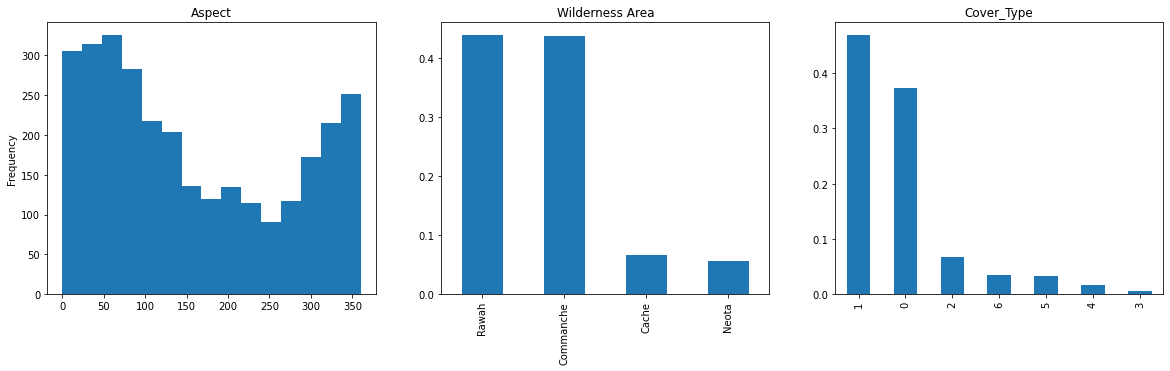

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
data_normal['Aspect'].plot.hist(bins=15, ax=axes[0], title='Aspect')
data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area')
data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[2], title=TARGET_FEATURE_NAME)

In [11]:
normal_days_data_list =[
                        data_normal[:1000],
                        data_normal[1000:2000],
                        data_normal[2000:]
]


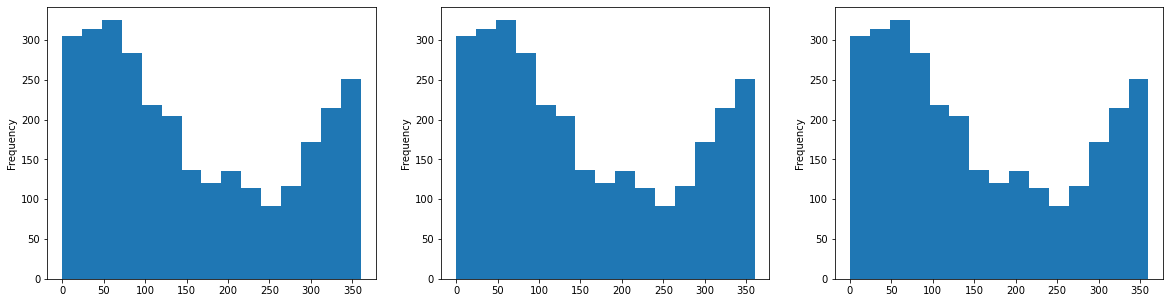

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Aspect'].plot.hist(bins=15, ax=axes[i])

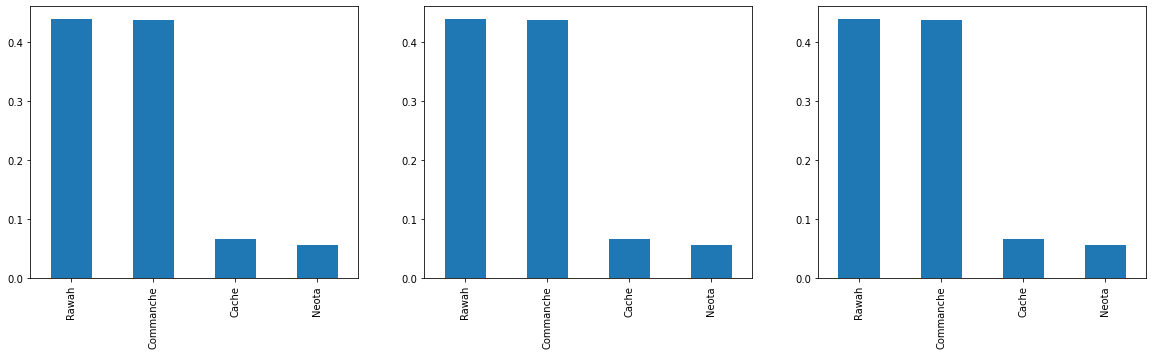

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[i])

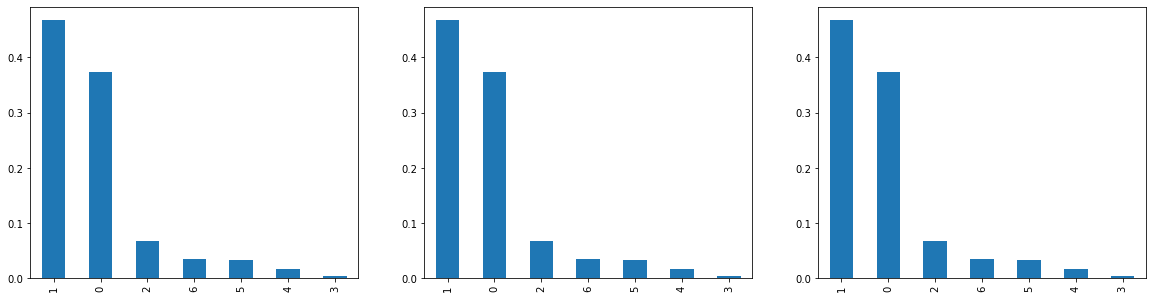

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[i])

In [15]:
serving_data['2020-04-01'] = normal_days_data_list[0]
serving_data['2020-04-02'] = normal_days_data_list[1]
serving_data['2020-04-03'] = normal_days_data_list[2]

## 4. Preparing Skewed Data
We are going to introduce the following skews to the data:
1. **Numerical Features**
  1. *Elevation - Feature Skew*: Convert the unit of measure from meters to kilometers in 2020-04-05
  2. *Aspect - Distribution Skew*: gradual decrease of the value

2. **Categorical Features**
  1. *Wilderness_Area - Feature Skew*: Adding a new category "Others" in 2020-04-05
  2. *Wilderness_Area - Distribution Skew*: Gradual increase of of the frequency of "Cache" and "Neota" values
3. **Target Features**: check the change of the distribution of predictied class labels

In [16]:
data_to_skew = data.sample(3000)
serving_data['2020-04-04'] = data_to_skew[:1000]
serving_data['2020-04-05'] = data_to_skew[1000:2000]
serving_data['2020-04-06'] = data_to_skew[2000:]

### 4.1 Skew numerical features

#### 4.1.1 Elevation Feature Skew

In [17]:
serving_data['2020-04-05']['Elevation'] = serving_data['2020-04-05']['Elevation'] / 1000

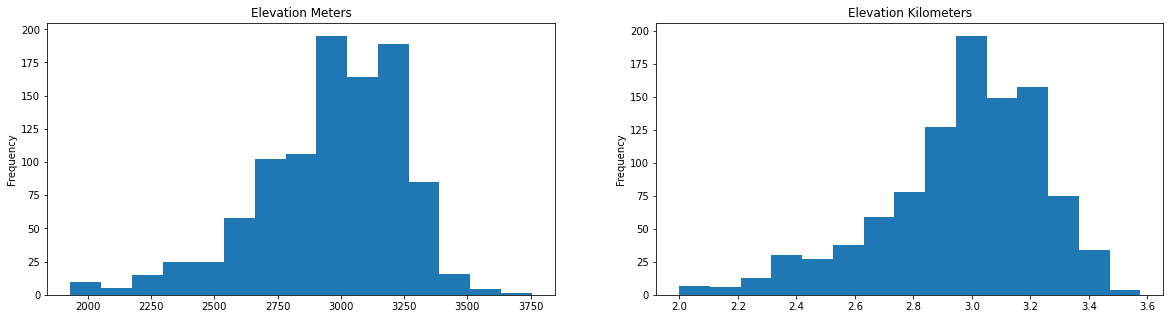

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
serving_data['2020-04-01']['Elevation'].plot.hist(bins=15, ax=axes[0], title='Elevation Meters')
serving_data['2020-04-05']['Elevation'].plot.hist(bins=15, ax=axes[1], title='Elevation Kilometers')

#### 4.1.2 Aspect Distribution Skew

In [19]:
serving_data['2020-04-04']['Aspect'] = serving_data['2020-04-04']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.90, 1) if value > 250 else value 
)

serving_data['2020-04-05']['Aspect'] = serving_data['2020-04-05']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.85, 1) if value > 250 else value 
)

serving_data['2020-04-06']['Aspect'] = serving_data['2020-04-06']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.80, 1) if value > 250 else value 
)

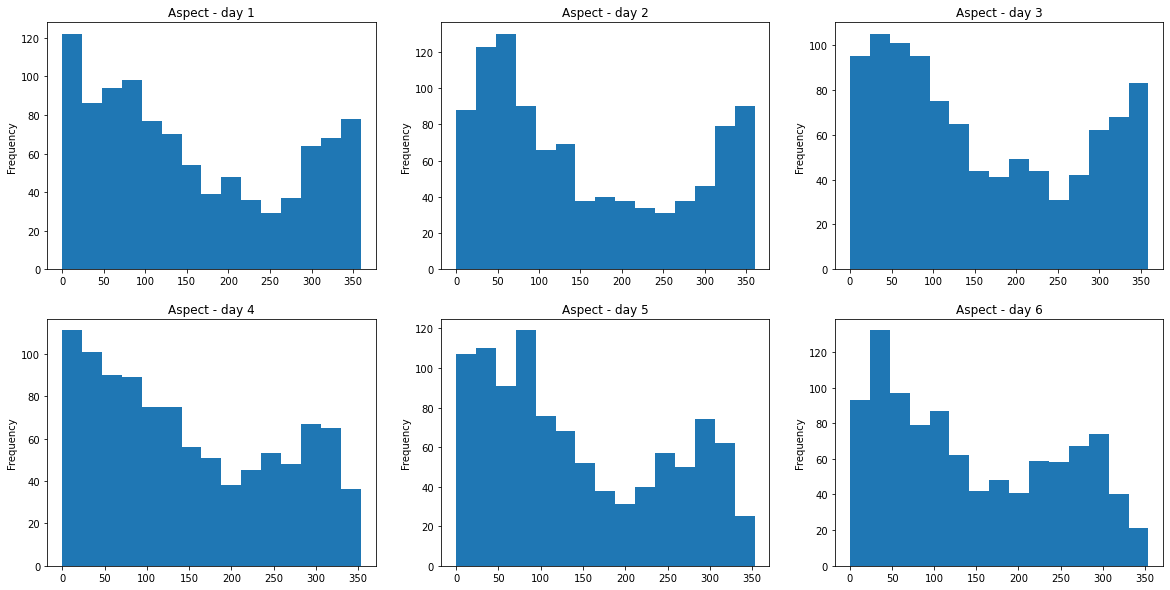

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Aspect'].plot.hist(bins=15, ax=axes[0, 0], title='Aspect - day 1')
serving_data['2020-04-02']['Aspect'].plot.hist(bins=15, ax=axes[0, 1], title='Aspect - day 2')
serving_data['2020-04-03']['Aspect'].plot.hist(bins=15, ax=axes[0, 2], title='Aspect - day 3')
serving_data['2020-04-04']['Aspect'].plot.hist(bins=15, ax=axes[1, 0], title='Aspect - day 4')
serving_data['2020-04-05']['Aspect'].plot.hist(bins=15, ax=axes[1, 1], title='Aspect - day 5')
serving_data['2020-04-06']['Aspect'].plot.hist(bins=15, ax=axes[1, 2], title='Aspect - day 6')

### 4.2 Skew categorical features

#### 4.2.1 Wilderness Area Feature Skew
Adding a new category "Others"


In [23]:
serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Others' if np.random.uniform() <= 0.1 else value
)

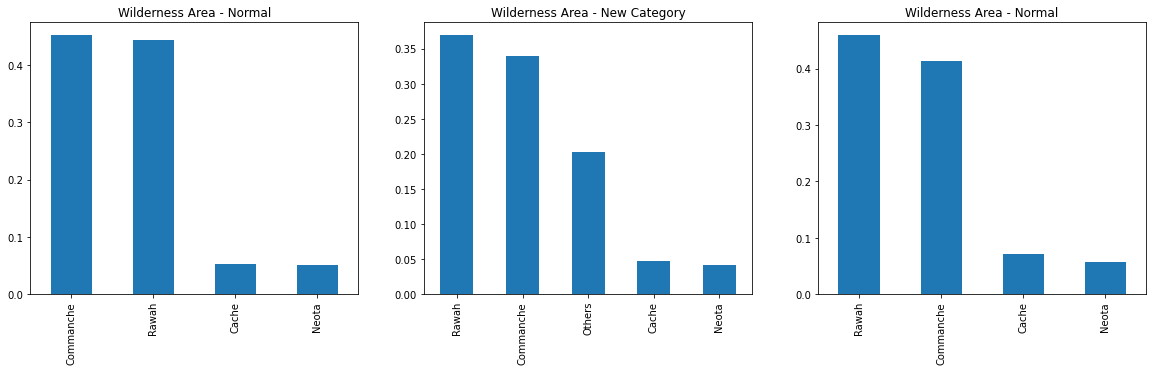

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0], title='Wilderness Area - Normal')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area - New Category')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[2], title='Wilderness Area - Normal')

#### 4.2.2 Wilderness Area Distribution Skew

In [25]:
serving_data['2020-04-04']['Wilderness_Area'] = serving_data['2020-04-04']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.1 else value
)

serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.15 else value
)

serving_data['2020-04-06']['Wilderness_Area'] = serving_data['2020-04-06']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.2 else value
)

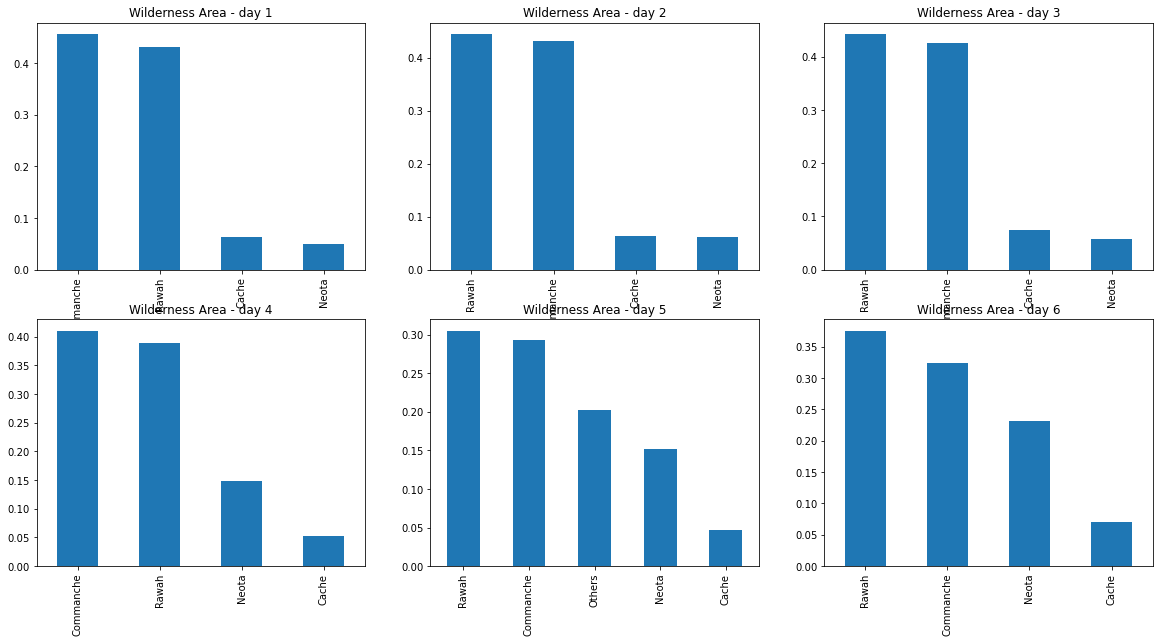

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 0], title='Wilderness Area - day 1')
serving_data['2020-04-02']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 1], title='Wilderness Area - day 2')
serving_data['2020-04-03']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 2], title='Wilderness Area - day 3')
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 0], title='Wilderness Area - day 4')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 1], title='Wilderness Area - day 5')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 2], title='Wilderness Area - day 6')


## 5. Simulating serving workload

### 5.1 Implement the model API client

In [39]:
partitions = {}
for time_stamp, data in serving_data.items():
    instances = []
    for _, row in data.iterrows():
        instance = {}
        for column_name in data.columns:
            if column_name == TARGET_FEATURE_NAME: continue
            instance[column_name] = [str(row[column_name])] if column_name in CATEGORICAL_FEATURE_NAMES else [row[column_name]]
        instances.append(instance)
    partitions[time_stamp] = instances




In [48]:
path_root = '/home/jarekk/repos/drift-monitor/online_prediction_simulater/skewed_data'

In [58]:
import json

for partition in partitions.keys():
    print(partition)
    tf_io.gfile.makedirs(path_root + '/' +partition)

2020-04-01
2020-04-02
2020-04-03
2020-04-04
2020-04-05
2020-04-06


In [63]:
for partition in partitions.keys():
    file_path = '{}/json-{}.txt'.format(path_root, partition)
    with open(file_path, 'w') as f:
        for instance in partitions[partition]:
            instance_json = json.dumps(instance)
            f.write(instance_json)
            f.write('\n')

    

In [0]:
import googleapiclient.discovery
import numpy as np

service = googleapiclient.discovery.build('ml', 'v1')
name = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION_NAME)
print("Service name: {}".format(name))

def caip_predict(instances):
  
  serving_instances = []
  for instance in instances:
    serving_instances.append(
        {key: [value] for key, value in instance.items()})
    
  request_body={
      'signature_name': SIGNATURE_NAME,
      'instances': serving_instances}

  response = service.projects().predict(
      name=name,
      body=request_body

  ).execute()

  if 'error' in response:
    raise RuntimeError(response['error'])

  probability_list = [output[MODEL_OUTPUT_KEY] for output in response['predictions']]
  classes = [FEATURE_LABELS[int(np.argmax(probabilities))] for probabilities in probability_list]
  return classes

### 5.2 Prepare the request instances

In [0]:
def prepare_instances(serving_data):
  instances = []

  for request_timestamp, data in serving_data.items():
    for _, row in data.iterrows():
      instance = dict()
      for column_name in data.columns:
        if column_name == TARGET_FEATURE_NAME: continue
        instance[column_name] = str(row[column_name]) if column_name in CATEGORICAL_FEATURE_NAMES else row[column_name]
      instance['request_timestamp'] = request_timestamp
      instances.append(instance)

  return instances


In [0]:
import time

def simulate_requests():
  instances = prepare_instances(serving_data)

  print("Simulation started...")
  print("--------------------")
  print("Number of instances: {}".format(len(instances)))

  for i, instance in enumerate(instances):
    predicted_class = caip_predict([instance])
    print(".", end='')
    
    if (i + 1) % 100 == 0:
      print()
      print("Sent {} requests.".format(i + 1))

    #time.sleep(0.1)
  print("")
  print("--------------------")
  print("Simulation finised.")
    

In [0]:
simulate_requests()